In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Accuracy

# **1. Get data**

In [2]:
# Step 1: Load both train and test text files
test_file_path = 'test.txt'    # Path to your test.txt file
train_file_path = 'train.txt'
# Specify the folders for train and test images
train_dir = './Train/'  # Folder where train images are stored
test_dir = './Test/'    # Folder where test images are stored

In [3]:
BATCH_SIZE = 32
IMG_SIZE = 224

In [4]:
# Load the train.txt into a pandas dataframe
train_labels = pd.read_csv(train_file_path, sep=" ", header=None, names=['image_path', 'class_label'])
test_labels = pd.read_csv(test_file_path, sep=" ", header=None, names=['image_path', 'class_label'])

# Function to load and preprocess images
def process_image(image_path, label, base_dir):
    # Concatenate the base directory with the image path using a list
    full_image_path = tf.strings.join([base_dir, image_path])
    
    # Load the image from the path
    image = tf.io.read_file(full_image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode JPEG image
    # Resize the image to a fixed size
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize the image to [0, 1]
    return image, label

# Create the dataset from the image paths and labels
def create_tf_dataset(image_paths, labels, base_dir):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(lambda image_path, label: process_image(image_path, label, base_dir),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

# Create the TensorFlow dataset
train_dataset_full = create_tf_dataset(train_labels['image_path'], train_labels['class_label'], train_dir)
test_dataset = create_tf_dataset(test_labels['image_path'], test_labels['class_label'], test_dir)

# Split the training dataset into train and validation datasets
validation_split = 0.2
total_size = len(train_labels)
val_size = int(total_size * validation_split)
train_size = total_size - val_size

# Shuffle and split
train_dataset_full = train_dataset_full.shuffle(buffer_size=total_size)
val_dataset = train_dataset_full.take(val_size)  # Validation set
train_dataset = train_dataset_full.skip(val_size)  # Training set

# Ensure batching and prefetching
train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)


In [5]:
# Extract the full class name by splitting the filename at '_' and slicing off the last two parts
train_labels['class_name'] = train_labels['image_path'].apply(lambda x: ' '.join(x.split('_')[:-2]))
# Create a list of unique class names in the order of their labels
class_names = train_labels[['class_name', 'class_label']].drop_duplicates().sort_values('class_label')['class_name'].tolist()
print(class_names)

['Black footed Albatross', 'Laysan Albatross', 'Sooty Albatross', 'Groove billed Ani', 'Crested Auklet', 'Least Auklet', 'Parakeet Auklet', 'Rhinoceros Auklet', 'Brewer Blackbird', 'Red winged Blackbird', 'Rusty Blackbird', 'Yellow headed Blackbird', 'Bobolink', 'Indigo Bunting', 'Lazuli Bunting', 'Painted Bunting', 'Cardinal', 'Spotted Catbird', 'Gray Catbird', 'Yellow breasted Chat', 'Eastern Towhee', 'Chuck will Widow', 'Brandt Cormorant', 'Red faced Cormorant', 'Pelagic Cormorant', 'Bronzed Cowbird', 'Shiny Cowbird', 'Brown Creeper', 'American Crow', 'Fish Crow', 'Black billed Cuckoo', 'Mangrove Cuckoo', 'Yellow billed Cuckoo', 'Gray crowned Rosy Finch', 'Purple Finch', 'Northern Flicker', 'Acadian Flycatcher', 'Great Crested Flycatcher', 'Least Flycatcher', 'Olive sided Flycatcher', 'Scissor tailed Flycatcher', 'Vermilion Flycatcher', 'Yellow bellied Flycatcher', 'Frigatebird', 'Northern Fulmar', 'Gadwall', 'American Goldfinch', 'European Goldfinch', 'Boat tailed Grackle', 'Eared 

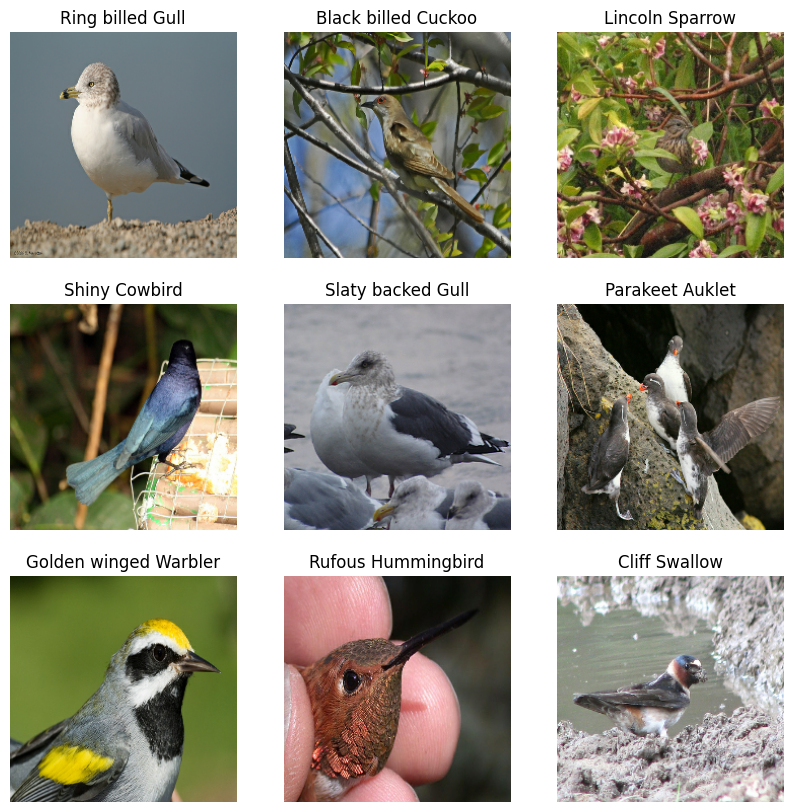

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(val_dataset))
print('Number of testing batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 31
Number of testing batches: 38


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [9]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2)
])


In [10]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

In [11]:
base_model = tf.keras.applications.ResNet50V2(input_shape=(IMG_SIZE,IMG_SIZE,3),
                                               include_top=False,
                                               weights='imagenet')

In [12]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 2048)


In [13]:
base_model.trainable = False

In [14]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "resnet50v2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,564,800 (89.89 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,564,800 (89.89 MB)

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(200, activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 200)


In [17]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = rescale(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,982,792 (91.49 MB)

 Trainable params: 413,896 (1.58 MB)

 Non-trainable params: 23,568,896 (89.91 MB)

In [19]:
len(model.trainable_variables)

4

In [20]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [21]:
initial_epochs = 20

loss0, accuracy0 = model.evaluate(val_dataset)

31/31 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.0022 - loss: 6.0755


In [22]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 6.02
initial accuracy: 0.00


In [23]:
history_initial = model.fit(train_dataset,            
                    epochs=initial_epochs,
                    validation_data=val_dataset
                    )

Epoch 1/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 127s 923ms/step - accuracy: 0.0550 - loss: 5.2370 - val_accuracy: 0.4010 - val_loss: 2.7685
Epoch 2/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 159s 1s/step - accuracy: 0.3446 - loss: 2.7988 - val_accuracy: 0.5813 - val_loss: 1.7813
Epoch 3/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.4885 - loss: 2.0942 - val_accuracy: 0.6301 - val_loss: 1.3753
Epoch 4/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 93s 765ms/step - accuracy: 0.5523 - loss: 1.7496 - val_accuracy: 0.7078 - val_loss: 1.1788
Epoch 5/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 99s 811ms/step - accuracy: 0.6150 - loss: 1.4561 - val_accuracy: 0.7171 - val_loss: 1.0463
Epoch 6/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step - accuracy: 0.6324 - loss: 1.4088 - val_accuracy: 0.7430 - val_loss: 0.9754
Epoch 7/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 245s 2s/step - accuracy: 0.6625 - loss: 1.2374 - val_accuracy: 0.7731 - val_loss: 0.8708
Epoch 8/20
121/121 ━━━━━━━━━━━━━━━━━━━━ 99s 809ms/step - accuracy: 0.6845 - loss: 1.1547 -

In [24]:
model.save('./nanh.keras')

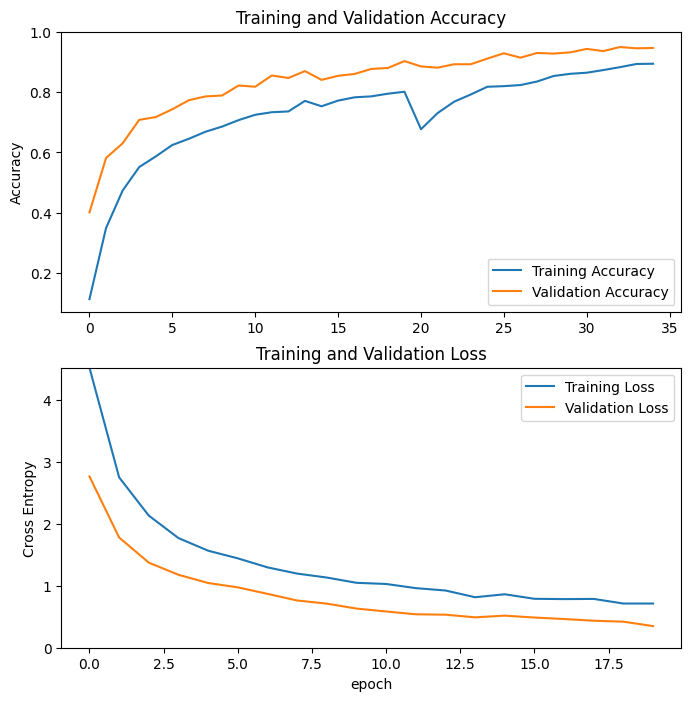

In [35]:
acc = history_initial.history['accuracy']
val_acc = history_initial.history['val_accuracy']

loss = history_initial.history['loss']
val_loss = history_initial.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0, max(max(loss), max(val_loss))])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
base_model.trainable = True

In [28]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  190


In [29]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate / 100),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [30]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50v2 (Functional)         │ (None, None, None,     │    23,564,800 │
│                                 │ 2048)                  │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,982,792 (91.49 MB)

 Trainable params: 20,973,768 (80.01 MB)

 Non-trainable params: 3,009,024 (11.48 MB)

In [31]:
len(model.trainable_variables)

86

In [32]:
fine_tune_epochs = 15
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=len(history_initial.epoch),
                         validation_data=val_dataset)

Epoch 21/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.6704 - loss: 1.2111 - val_accuracy: 0.8850 - val_loss: 0.4242
Epoch 22/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.7308 - loss: 0.9588 - val_accuracy: 0.8808 - val_loss: 0.4298
Epoch 23/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.7624 - loss: 0.8316 - val_accuracy: 0.8922 - val_loss: 0.4008
Epoch 24/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.7841 - loss: 0.7349 - val_accuracy: 0.8922 - val_loss: 0.3192
Epoch 25/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 266s 2s/step - accuracy: 0.8224 - loss: 0.6578 - val_accuracy: 0.9109 - val_loss: 0.3545
Epoch 26/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 267s 2s/step - accuracy: 0.8216 - loss: 0.6134 - val_accuracy: 0.9285 - val_loss: 0.2510
Epoch 27/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8198 - loss: 0.6226 - val_accuracy: 0.9140 - val_loss: 0.3066
Epoch 28/35
121/121 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - accuracy: 0.8369 - loss: 0.5433 - 

In [36]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']
loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

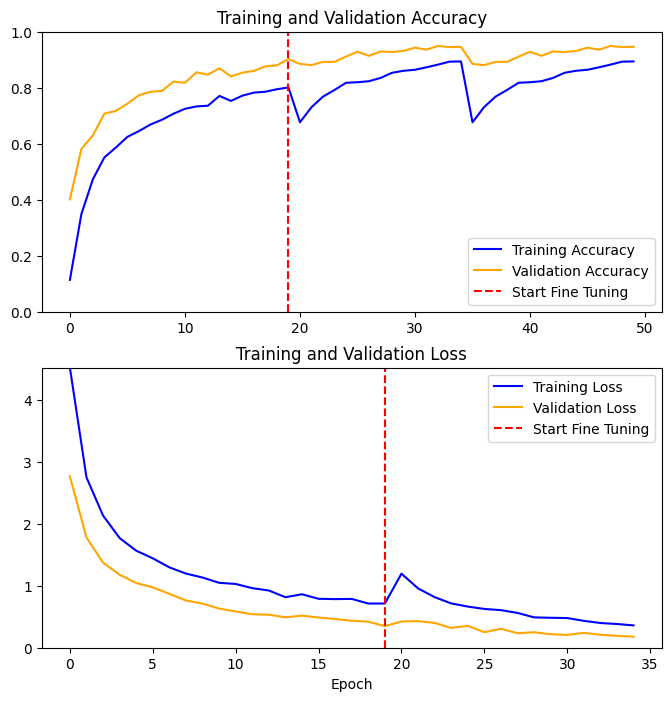

In [37]:
# Plotting
plt.figure(figsize=(8, 8))

# Plotting Accuracy
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', color='blue')
plt.plot(val_acc, label='Validation Accuracy', color='orange')
plt.ylim([0, 1])  # Adjust the y-limit to fit your data range
plt.axvline(x=initial_epochs - 1, color='r', linestyle='--', label='Start Fine Tuning')  # Vertical line for fine-tuning
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting Loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.ylim([0, max(max(loss), max(val_loss))])  # Set the y-limit based on max values
plt.axvline(x=initial_epochs - 1, color='r', linestyle='--', label='Start Fine Tuning')  # Vertical line for fine-tuning
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.show()


In [34]:
model.save('./nanh_final.keras')

In [38]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

# Initialize the accuracy metric
top_1_accuracy = Accuracy()

# Get the model predictions and true labels
predictions = []
true_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    predictions.extend(np.argmax(preds, axis=1))  # Append predicted classes
    true_labels.extend(labels.numpy())  # Convert labels from TensorFlow tensor to numpy array

# Convert predictions and true labels to numpy arrays
predicted_classes = np.array(predictions)
true_labels = np.array(true_labels)

# Convert to TensorFlow tensors for accuracy calculation
test_labels_tensor = tf.convert_to_tensor(true_labels, dtype=tf.int32)
predicted_classes_tensor = tf.convert_to_tensor(predicted_classes, dtype=tf.int32)

# Compute Top-1 Accuracy
top_1_accuracy.update_state(test_labels_tensor, predicted_classes_tensor)
top_1_accuracy_result = top_1_accuracy.result().numpy()

print(f"Top-1 Accuracy: {top_1_accuracy_result * 100:.2f}%")

# Initialize variables for calculating average accuracy per class
num_classes = 200  # Example for CUB-200 dataset
class_correct = np.zeros(num_classes)
class_total = np.zeros(num_classes)

# Calculate per-class accuracy
for i in range(len(true_labels)):
    label = true_labels[i]
    pred = predicted_classes[i]
    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

# Avoid division by zero
class_accuracies = np.zeros(num_classes)
for i in range(num_classes):
    if class_total[i] > 0:
        class_accuracies[i] = class_correct[i] / class_total[i]

# Compute average accuracy per class
average_accuracy_per_class = np.mean(class_accuracies)
print(f"Average Accuracy Per Class: {average_accuracy_per_class * 100:.2f}%")

38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 996ms/step - accuracy: 0.5865 - loss: 2.2242
Test loss: 2.3766465187072754
Test accuracy: 0.5606312155723572
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 962ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 976ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 982ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 970ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 980ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 994ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 987ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 993ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 979ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 961ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 971ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 985ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 965ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 975ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━